In [2]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\dhruv
['.anaconda', '.bash_history', '.conda', '.condarc', '.continuum', '.eclipse', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lesshst', '.matplotlib', '.p2', '.streamlit', '.swt', '.VirtualBox', '.vscode', 'anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Diwali Sales Data.csv', 'Documents', 'Downloads', 'eclipse', 'eclipse-workspace', 'eda.ipynb', 'Favorites', 'Links', 'Local Settings', 'Microsoft', 'ml lab.ipynb', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TM.blf', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'placement.csv', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'train.csv', 'Untitled.ipynb', 'Untitled1.ipynb', 'Videos', 'Vi

In [3]:
df = pd.read_csv("train.csv")


In [4]:
df.shape

(913000, 4)

In [5]:
df["date"] = pd.to_datetime(df["date"])
df.dtypes


date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
daily_store_demand = (
    df.groupby(["date", "store"])["sales"]
      .sum()
      .reset_index()
)

daily_store_demand.head()


,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


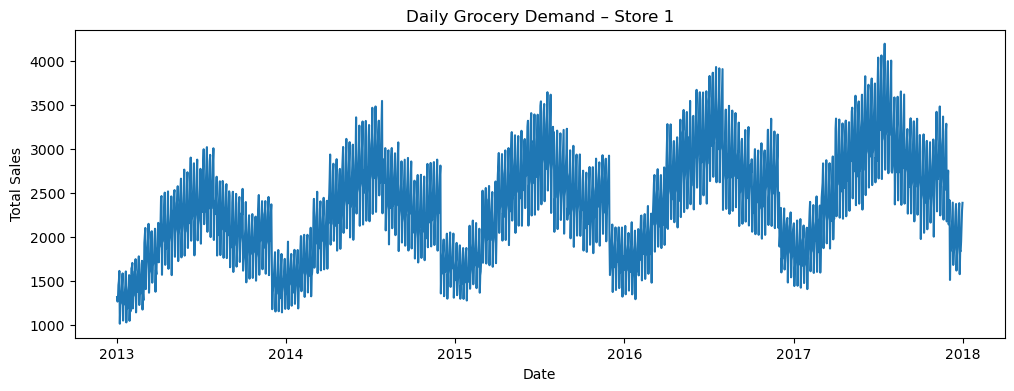

In [7]:
import matplotlib.pyplot as plt

store_id = 1
store_data = daily_store_demand[daily_store_demand["store"] == store_id]

plt.figure(figsize=(12,4))
plt.plot(store_data["date"], store_data["sales"])
plt.title(f"Daily Grocery Demand – Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


## inventory + stock-out prediction logic

In [9]:
# Sort data (important)
store_data = store_data.sort_values("date")

# Rolling average demand (7-day)
store_data["avg_daily_demand"] = store_data["sales"].rolling(window=7).mean()

store_data.head(10)


,date,store,sales,avg_daily_demand
0,2013-01-01,1,1316,NaN
10,2013-01-02,1,1264,NaN
20,2013-01-03,1,1305,NaN
30,2013-01-04,1,1452,NaN
40,2013-01-05,1,1499,NaN
50,2013-01-06,1,1613,NaN
60,2013-01-07,1,1012,1351.571429
70,2013-01-08,1,1228,1339.000000
80,2013-01-09,1,1243,1336.000000
90,2013-01-10,1,1339,1340.857143


In [10]:
SAFETY_DAYS = 10

store_data["estimated_inventory"] = store_data["avg_daily_demand"] * SAFETY_DAYS

store_data[["date", "sales", "avg_daily_demand", "estimated_inventory"]].head(10)


,date,sales,avg_daily_demand,estimated_inventory
0,2013-01-01,1316,NaN,NaN
10,2013-01-02,1264,NaN,NaN
20,2013-01-03,1305,NaN,NaN
30,2013-01-04,1452,NaN,NaN
40,2013-01-05,1499,NaN,NaN
50,2013-01-06,1613,NaN,NaN
60,2013-01-07,1012,1351.571429,13515.714286
70,2013-01-08,1228,1339.000000,13390.000000
80,2013-01-09,1243,1336.000000,13360.000000
90,2013-01-10,1339,1340.857143,13408.571429


In [11]:
store_data["days_of_stock_left"] = (
    store_data["estimated_inventory"] / store_data["avg_daily_demand"]
)


In [12]:
def risk_level(days):
    if days < 3:
        return "High Risk"
    elif days < 7:
        return "Medium Risk"
    else:
        return "Low Risk"

store_data["risk_level"] = store_data["days_of_stock_left"].apply(risk_level)

store_data[["date", "days_of_stock_left", "risk_level"]].tail(10)


,date,days_of_stock_left,risk_level
18160,2017-12-22,10.0,Low Risk
18170,2017-12-23,10.0,Low Risk
18180,2017-12-24,10.0,Low Risk
18190,2017-12-25,10.0,Low Risk
18200,2017-12-26,10.0,Low Risk
18210,2017-12-27,10.0,Low Risk
18220,2017-12-28,10.0,Low Risk
18230,2017-12-29,10.0,Low Risk
18240,2017-12-30,10.0,Low Risk
18250,2017-12-31,10.0,Low Risk


## GENERALIZE INVENTORY & RISK FOR ALL STORES

In [13]:
# Sort full dataset
daily_store_demand = daily_store_demand.sort_values(["store", "date"])
daily_store_demand.head()


,date,store,sales
0,2013-01-01,1,1316
10,2013-01-02,1,1264
20,2013-01-03,1,1305
30,2013-01-04,1,1452
40,2013-01-05,1,1499


In [14]:
daily_store_demand["avg_daily_demand"] = (
    daily_store_demand
    .groupby("store")["sales"]
    .rolling(window=7)
    .mean()
    .reset_index(level=0, drop=True)
)


In [15]:
SAFETY_DAYS = 10

daily_store_demand["estimated_inventory"] = (
    daily_store_demand["avg_daily_demand"] * SAFETY_DAYS
)


In [16]:
daily_store_demand["days_of_stock_left"] = (
    daily_store_demand["estimated_inventory"] /
    daily_store_demand["avg_daily_demand"]
)


In [17]:
def risk_level(days):
    if pd.isna(days):
        return "Unknown"
    elif days < 3:
        return "High Risk"
    elif days < 7:
        return "Medium Risk"
    else:
        return "Low Risk"

daily_store_demand["risk_level"] = (
    daily_store_demand["days_of_stock_left"].apply(risk_level)
)

daily_store_demand.tail()


,date,store,sales,avg_daily_demand,estimated_inventory,days_of_stock_left,risk_level
18219,2017-12-27,10,2221,2460.000000,24600.000000,10.0,Low Risk
18229,2017-12-28,10,2429,2448.714286,24487.142857,10.0,Low Risk
18239,2017-12-29,10,2687,2461.571429,24615.714286,10.0,Low Risk
18249,2017-12-30,10,2742,2461.857143,24618.571429,10.0,Low Risk
18259,2017-12-31,10,2939,2477.000000,24770.000000,10.0,Low Risk


In [18]:
latest_date = daily_store_demand["date"].max()

current_status = daily_store_demand[
    daily_store_demand["date"] == latest_date
]

current_status[["store", "sales", "risk_level"]].head()


,store,sales,risk_level
18250,1,2388,Low Risk
18251,2,3370,Low Risk
18252,3,3086,Low Risk
18253,4,2844,Low Risk
18254,5,1974,Low Risk
